# Heart Failure Prediction

This project implements a multi-model comparative analysis to predict the presence of heart disease using a clinical dataset of 918 observations.

---
**Dataset:** [Kaggle – Heart Failure Prediction](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data) — 11 clinical features including EKG metrics (ST_Slope, Oldpeak) and patient biometrics.  
**Models:** Logistic Regression · SVM · XGBoost · MLP (PyTorch)

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay, f1_score, accuracy_score,
    recall_score, precision_score
)

import xgboost as xgb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import json, os, random, warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
SEED = 42
np.random.seed(SEED)

# Load Data

In [3]:
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump({"username": "YOUR_USERNAME", "key": "YOUR_KEY"}, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)
!kaggle datasets download -d fedesoriano/heart-failure-prediction
!unzip heart-failure-prediction.zip && rm heart-failure-prediction.zip

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 19.3MB/s]
Archive:  heart-failure-prediction.zip
  inflating: heart.csv               


In [4]:
df = pd.read_csv('heart.csv')

In [5]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [8]:
df.duplicated().sum()

np.int64(0)

**Notes:**
- All 918 rows are non-null and duplicate-free; each row is a unique clinical observation.
- The average patient is 53 years old — a middle-aged to elderly cohort.
- `Cholesterol` min is 0.0: physiologically impossible, indicating missing data encoded as zero.
- `Oldpeak` max of 6.2 is ~6 standard deviations above the mean; the distribution is right-skewed with potential outliers that StandardScaler will handle.
- `FastingBS` appears numeric but is categorical: 1 if fasting blood sugar > 120 mg/dl, 0 otherwise.

# Exploratory Data Analysis (EDA)

### Target Distribution

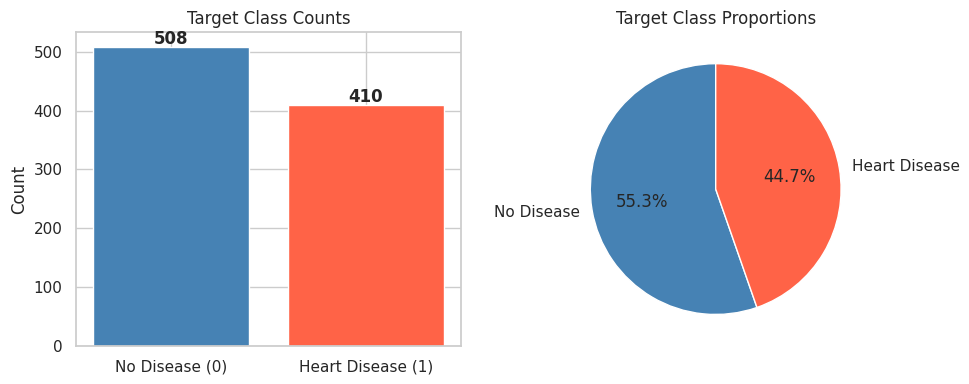

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
counts = df['HeartDisease'].value_counts()
axes[0].bar(['No Disease (0)', 'Heart Disease (1)'], counts.values, color=['steelblue', 'tomato'])
axes[0].set_title('Target Class Counts')
axes[0].set_ylabel('Count')
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')
axes[1].pie(counts.values, labels=['No Disease', 'Heart Disease'],
            autopct='%1.1f%%', colors=['steelblue', 'tomato'], startangle=90)
axes[1].set_title('Target Class Proportions')
plt.tight_layout()
plt.show()

**Notes:**
- The dataset is **near-balanced** (~55% HD, ~45% No HD).
- With only 918 samples, robust cross-validation is essential to avoid overfitting.

### Gender Distribution

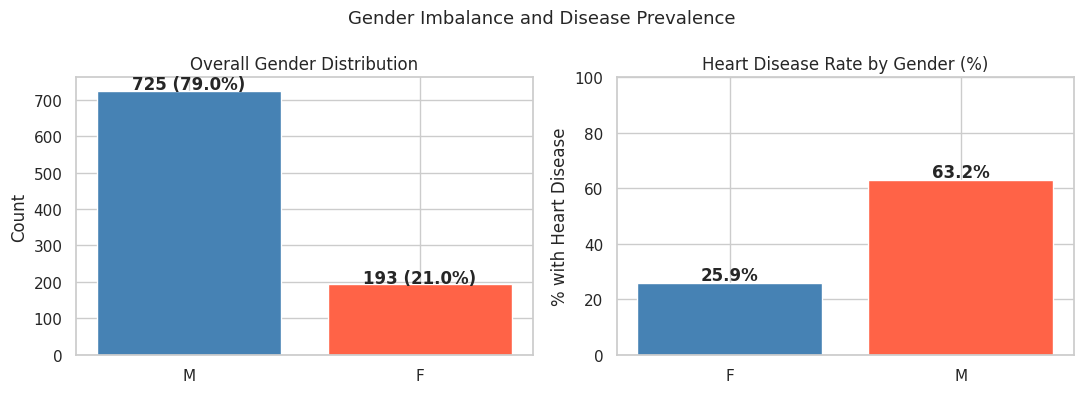

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Overall gender split
gender_counts = df['Sex'].value_counts()
axes[0].bar(gender_counts.index, gender_counts.values, color=['steelblue', 'tomato'])
axes[0].set_title('Overall Gender Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(gender_counts.values):
    axes[0].text(i, v + 5, f'{v} ({100*v/len(df):.1f}%)', ha='center', fontweight='bold')

# HD rate by gender
hd_by_sex = df.groupby('Sex')['HeartDisease'].mean() * 100
axes[1].bar(hd_by_sex.index, hd_by_sex.values, color=['steelblue', 'tomato'])
axes[1].set_title('Heart Disease Rate by Gender (%)')
axes[1].set_ylabel('% with Heart Disease')
axes[1].set_ylim(0, 100)
for i, v in enumerate(hd_by_sex.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.suptitle('Gender Imbalance and Disease Prevalence', fontsize=13)
plt.tight_layout()
plt.show()

**Notes:**
- The dataset has a significant **gender imbalance**: 79% male vs 21% female.
- Males have a substantially higher HD rate (63.2%) compared to females (25.9%), consistent with known epidemiology.
- Because of both the gender imbalance and differing disease rates, we use a **combined stratification key** (sex + target) in cross-validation to ensure every fold preserves these proportions.

### Numeric Feature Distributions by Class

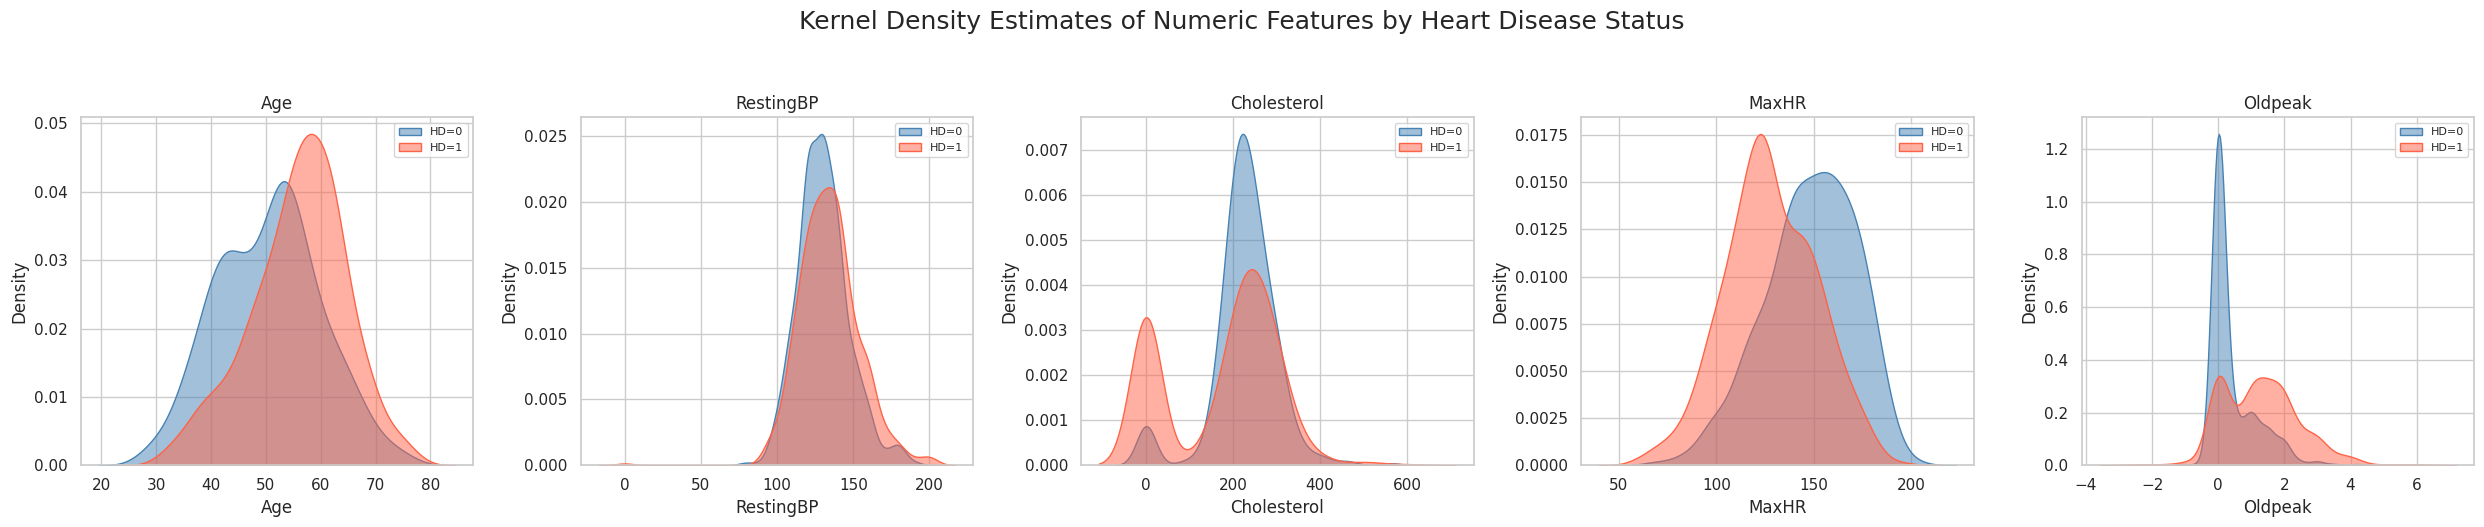

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, col in enumerate(num_cols):
    for label, color in zip([0, 1], ['steelblue', 'tomato']):
        # Using sns.kdeplot for the smooth "flattened" look
        sns.kdeplot(data=df[df['HeartDisease'] == label][col],
                    fill=True,
                    color=color,
                    label=f'HD={label}',
                    ax=axes[i],
                    alpha=0.5)

    axes[i].set_title(col)
    axes[i].legend(fontsize=8)

plt.suptitle('Kernel Density Estimates of Numeric Features by Heart Disease Status', fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

**Notes:**
- **Age:** Heart disease patients tend to be *older*. The distribution shifts right for HD=1.
- **Cholesterol:** Many values are exactly 0 (missing data encoded as zero), which makes the distribution unreliable for predication. This will need imputation during preprocessing.
- **MaxHR:** Patients with heart disease has notably *lower* maximum heart rate.
- **Oldpeak:** Heart disease patients show *higher* ST depression values.

### Boxplots — Numeric Features by Class

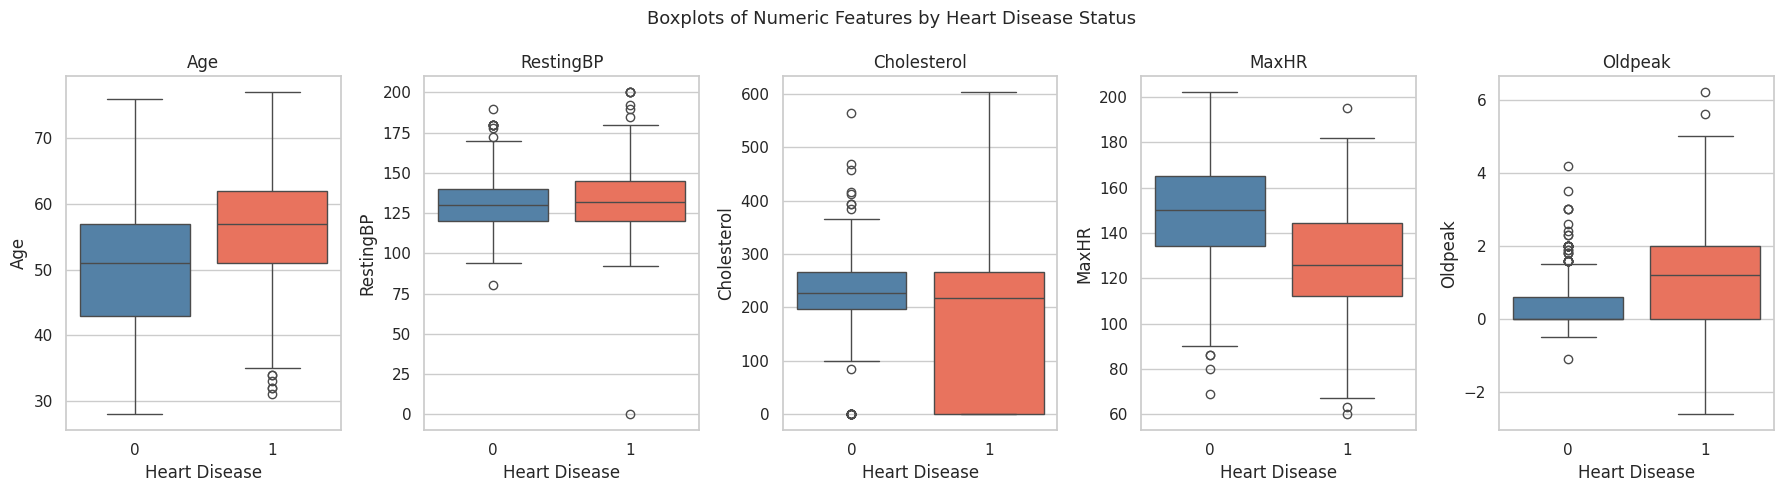

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='HeartDisease', y=col, ax=axes[i],
                palette={'0': 'steelblue', '1': 'tomato'})
    axes[i].set_title(col)
    axes[i].set_xlabel('Heart Disease')
plt.suptitle('Boxplots of Numeric Features by Heart Disease Status', fontsize=13)
plt.tight_layout()
plt.show()

**Notes:**
- **Age**: HD=1 shows a higher median and a tighter IQR around older ages, whiel HD=0 shows a lower median and more variability towards younger ages.
- **RestingBP**: Significant outliers exist at both extremes (0 and 200). The 0-value is a data entry error, while values near 200 might show hypertensive crises.
- **Cholesterol**: HD=1 is heavily skewed downward because of 0 values (missing values), which makes HD=1 has lower median than HD=0. This must be addressed because the result is clinically irrelevant (total cholesterol cannot be 0 and lower total cholesterol does not signal heart diseases).
- **MaxHR**: HD=1 median is significantly lower than HD=0, confirming that a reduced maximum heart rate is a strong separator.
- **Oldpeak**: HD=1 median is significantly higher than HD=0, suggesting that ST depression is a strong separator.

### Categorical Features vs. Heart Disease

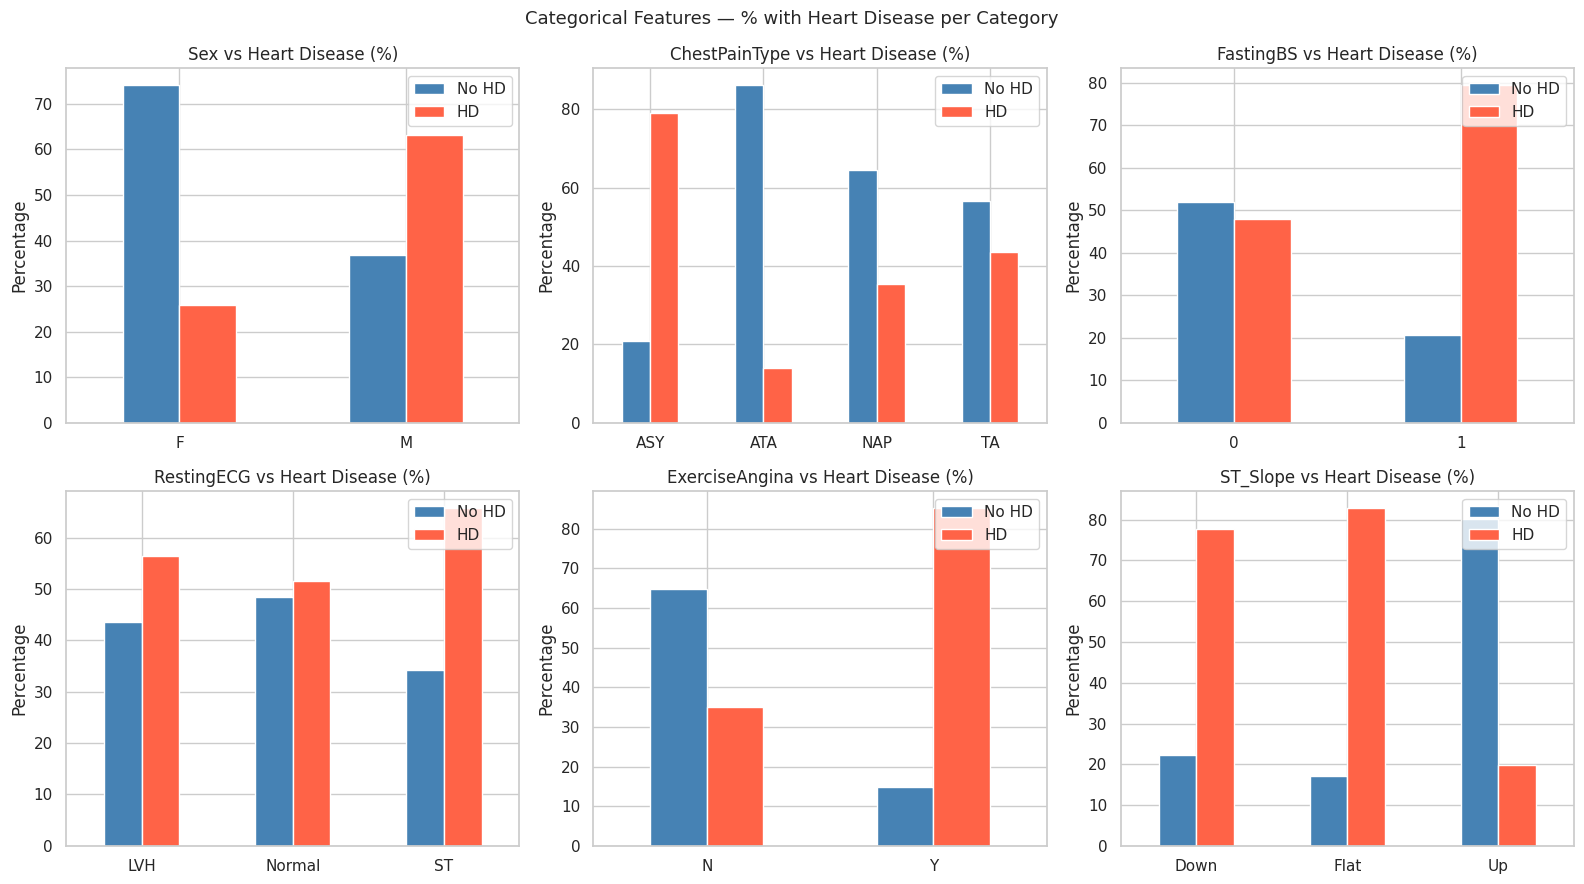

In [19]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    ct = pd.crosstab(df[col], df['HeartDisease'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[i], color=['steelblue', 'tomato'], edgecolor='white')
    axes[i].set_title(f'{col} vs Heart Disease (%)')
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('')
    axes[i].legend(['No HD', 'HD'], loc='upper right')
    axes[i].tick_params(axis='x', rotation=0)
plt.suptitle('Categorical Features — % with Heart Disease per Category', fontsize=13)
plt.tight_layout()
plt.show()

**Notes:**
- **Sex:** Males exhibit a significantly higher prevalence of heart disease than females. This confirms gender as a primary demographic risk factor.
- **ChestPainType:** Asymptomatic (ASY) has the highest heart disease rate. This is notable because patients who feel no chest pain are the highest-risk group.
- **FastingBS**: Patients with high fasting blood sugar (encoded as 1) show a much higher incidence of heart disease (~80%) compared to those in the normal range.
- **RestingECG**: ST segment abnormalities and LVH (Left Ventricular Hypertrophy) are stronger indicators of disease than a normal reading, though normal reading does not rule out risk.
- **ExerciseAngina:** A majority of patients who experience angina during exercise (~85%) are diagnosed with heart disease.
- **ST_Slope:** A 'Flat' or 'Down' ST slope is strongly associated with heart disease, while 'Up' slope is associated with being healthy.

### Correlation Heatmap (Raw Data)

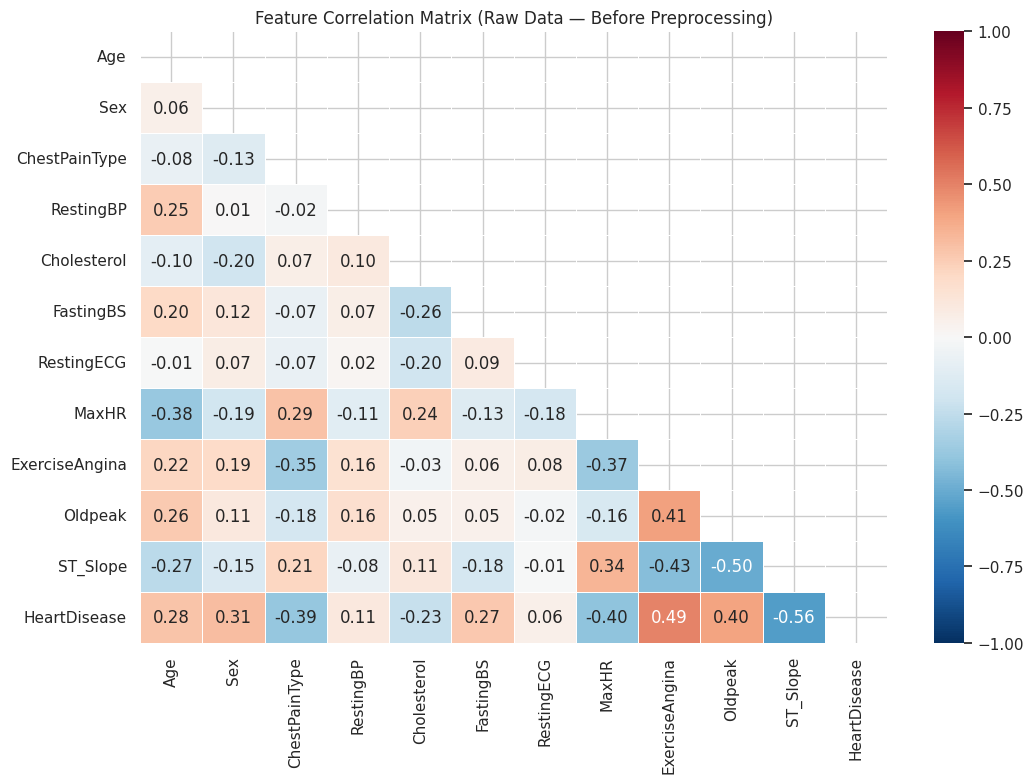

In [20]:
df_enc_raw = df.copy()
for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']:
    df_enc_raw[col] = LabelEncoder().fit_transform(df_enc_raw[col])

plt.figure(figsize=(11, 8))
corr = df_enc_raw.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlation Matrix (Raw Data — Before Preprocessing)')
plt.tight_layout()
plt.show()

**Notes:**


---
**Highly prevalent features**:
- **ST_Slope**: Confirms the overwhelming link between "Flat/Down" slopes and positive diagnosis. This is the strongest single predictor in the dataset.
- **ExerciseAngina**: Confirms that exercise-induced pain is a top-tier indicator of heart failure.
- **Oldpeak**: Confirms that higher ST depression values are strongly associated with heart disease.
- **MaxHR**: Confirms that a lower maximum heart rate achieved is a significant red flag.
---
**Prevalent features**:
- **Sex**: Shows a moderate correlation, confirming males have a higher incidence in this cohort.
- **Age**: Confirms the expected trend that risk increases with age.
- **FastingBS**: Confirms that elevated blood sugar is a reliable secondary indicator.
---
**Appears weak in raw heatmap:**
- **Cholesterol, RestingBP, RestingECG** show near-zero correlation here, but this can be because of dirty data.
Cholesterol has ~18% zero-encoded missing values, and RestingBP has at least one 0-value entry error.
---
**Feature intercorrelations motivating feature engineering:**
- **Oldpeak ↔ ST_Slope:** r ≈ -0.50 — two strong predictors that share meaningful variance.
- **ExerciseAngina ↔ Oldpeak:** r ≈ +0.40 — both reflect cardiac stress under exertion.
- **Age ↔ MaxHR:** r ≈ -0.39 — confirms the natural decline of max heart rate with age.

### Pairplot of Key Features

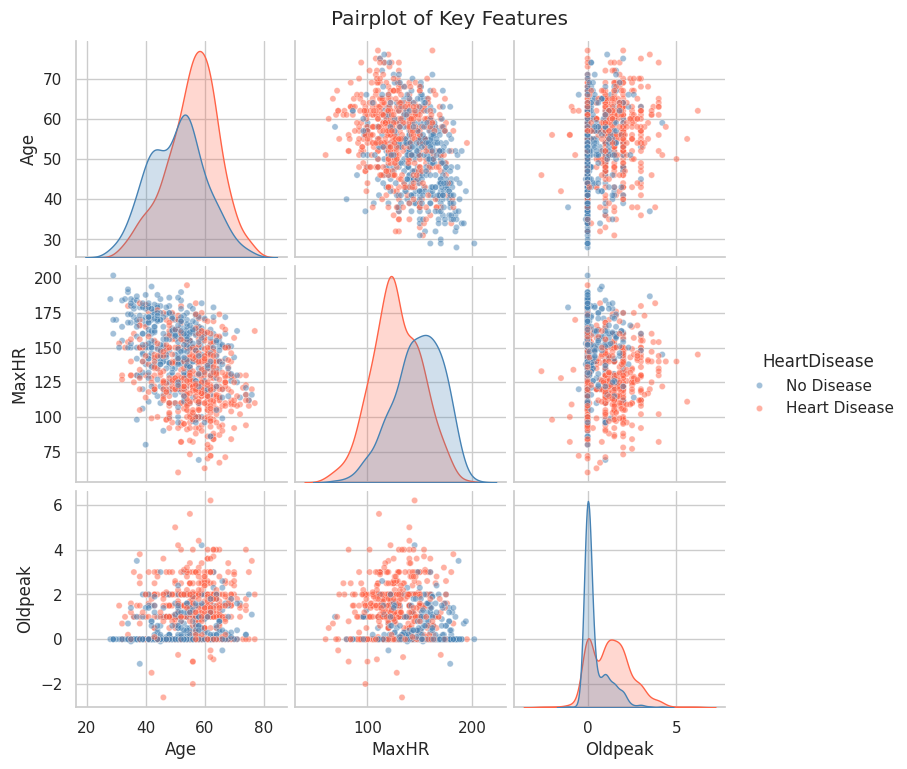

In [21]:
key_features = ['Age', 'MaxHR', 'Oldpeak', 'HeartDisease']
pair_df = df[key_features].copy()
pair_df['HeartDisease'] = pair_df['HeartDisease'].map({0: 'No Disease', 1: 'Heart Disease'})
g = sns.pairplot(pair_df, hue='HeartDisease',
                 palette={'No Disease': 'steelblue', 'Heart Disease': 'tomato'},
                 plot_kws={'alpha': 0.5, 's': 20}, diag_kind='kde')
g.fig.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

**Insights:**
- **Age vs. MaxHR:** Clear negative slope. As patients age, max HR declines naturally, but HD=1 patients sit consistently lower on the y-axis across all ages.
- **Age vs. Oldpeak:** Older patients with high Oldpeak cluster almost exclusively in the HD=1 group.
- **MaxHR vs. Oldpeak:** The cleanest 2D separation. HD=0 cluster in the top-left (high MaxHR, low Oldpeak); HD=1 dominates the bottom-right (low MaxHR, high Oldpeak).

# Data Preprocessing

In [22]:
df_clean = df.copy()

## Handle Missing Values (Cholesterol & RestingBP Zeros)

In [23]:
# Cholesterol: impute zeros with sex-group median (physiologically informed)
for sex in df_clean['Sex'].unique():
    median_val = df_clean[(df_clean['Sex'] == sex) & (df_clean['Cholesterol'] > 0)]['Cholesterol'].median()
    df_clean.loc[(df_clean['Sex'] == sex) & (df_clean['Cholesterol'] == 0), 'Cholesterol'] = median_val

# RestingBP: one patient has RestingBP = 0, also a data entry error
bp_median = df_clean[df_clean['RestingBP'] > 0]['RestingBP'].median()
df_clean.loc[df_clean['RestingBP'] == 0, 'RestingBP'] = bp_median

print("Zero Cholesterol remaining:", (df_clean['Cholesterol'] == 0).sum())
print("Zero RestingBP remaining:", (df_clean['RestingBP'] == 0).sum())

Zero Cholesterol remaining: 0
Zero RestingBP remaining: 0


## Encode Categoricals

In [24]:
# Binary: label encode
df_clean['Sex'] = (df_clean['Sex'] == 'M').astype(int)
df_clean['ExerciseAngina'] = (df_clean['ExerciseAngina'] == 'Y').astype(int)

# Multi-class: one-hot encode
df_clean = pd.get_dummies(df_clean, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=False)

# FastingBS is already binary (0/1)
print("Shape after encoding:", df_clean.shape)
df_clean.head(3)

Shape after encoding: (918, 19)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,False,True,False,False,False,True,False,False,False,True
1,49,0,160,180,0,156,0,1.0,1,False,False,True,False,False,True,False,False,True,False
2,37,1,130,283,0,98,0,0.0,0,False,True,False,False,False,False,True,False,False,True


## Post-Preprocessing Correlation Heatmap

With one-hot encoding, the full feature matrix is too wide for a readable heatmap. Instead, we use a **clustered heatmap** (`clustermap`) restricted to numeric features only — it reorders rows and columns by similarity, making structure much easier to read.

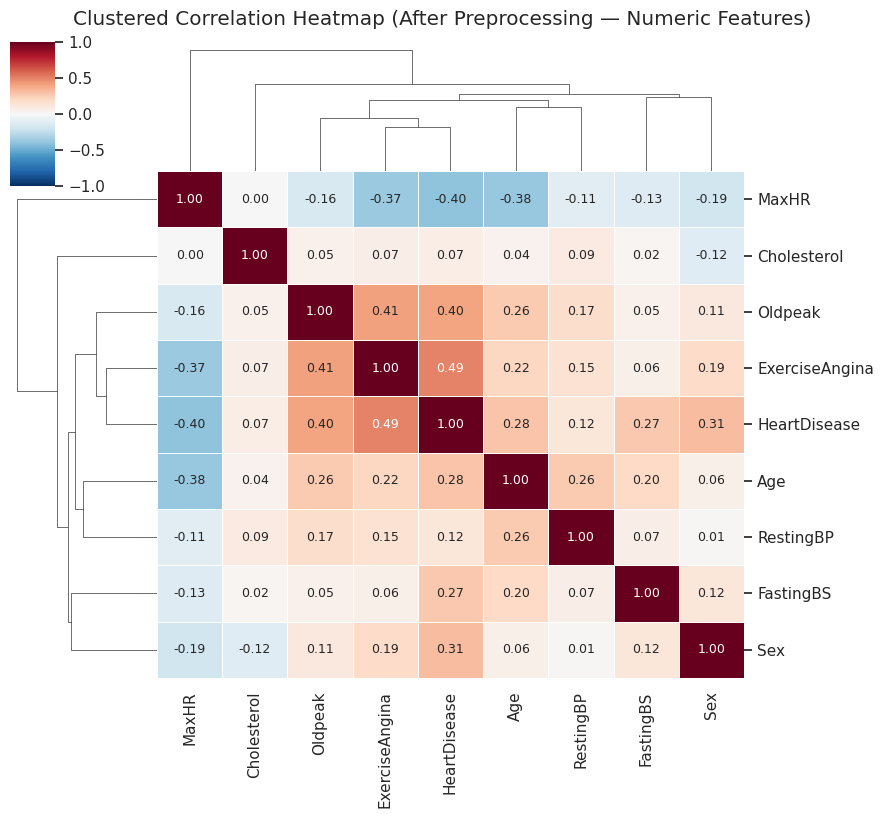

In [27]:
# Select numeric-only features for the post-processing heatmap
numeric_only = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
                'FastingBS', 'Sex', 'ExerciseAngina', 'HeartDisease']
corr_clean = df_clean[numeric_only].corr()

g = sns.clustermap(corr_clean, annot=True, fmt='.2f', cmap='RdBu_r',
                   center=0, vmin=-1, vmax=1, figsize=(9, 8),
                   linewidths=0.5, annot_kws={'size': 9})
g.fig.suptitle('Clustered Correlation Heatmap (After Preprocessing — Numeric Features)', y=1.02)
plt.show()

**Notes:**
- After imputing zeros, ``Cholesterol`` and ``RestingBP`` show cleaner (though still modest) correlations, confirming the raw heatmap's weakness was data quality, not clinical irrelevance.
- The clustermap groups `ExerciseAngina`, `Oldpeak`, and `HeartDisease` into one cluster, visually confirming their shared predictive direction.
- `MaxHR` clusters opposite `HeartDisease`, which a clean negative association.

# Feature Engineering

## HR Efficiency (Age + MaxHR)

`Age` and `MaxHR` are negatively correlated. A MaxHR of 130 means very different things for a 30-year-old vs. a 70-year-old. `HR_Efficiency` captures how close a patient is to their age-predicted maximum heart rate (Tanaka formula: 220 − age). A value near 1.0 is healthy; well below 1.0 is a risk signal.

In [28]:
df_clean['HR_Efficiency'] = df_clean['MaxHR'] / (220 - df_clean['Age'])

## EKG Score (ST_Slope + Oldpeak)

`ST_Slope` and `Oldpeak` are both strong predictors (r ≈ -0.50 with each other). We combine them additively so that Oldpeak still contributes signal even when ST_Slope is Up (low-risk). Risk weights: Up = 0, Flat = 1, Down = 2.


In [29]:
slope_weight = (df_clean['ST_Slope_Flat'] * 1 + df_clean['ST_Slope_Down'] * 2)
df_clean['EKG_Score'] = df_clean['Oldpeak'] + slope_weight

## Stress Impact (ExerciseAngina + Oldpeak)

`ExerciseAngina` and `Oldpeak` both reflect how the heart responds under physical stress. We combine them additively, weighting ExerciseAngina more heavily since it is a strong binary signal.

In [30]:
df_clean['Stress_Impact'] = df_clean['Oldpeak'] + 2 * df_clean['ExerciseAngina']

## Validation after Feature Engineering

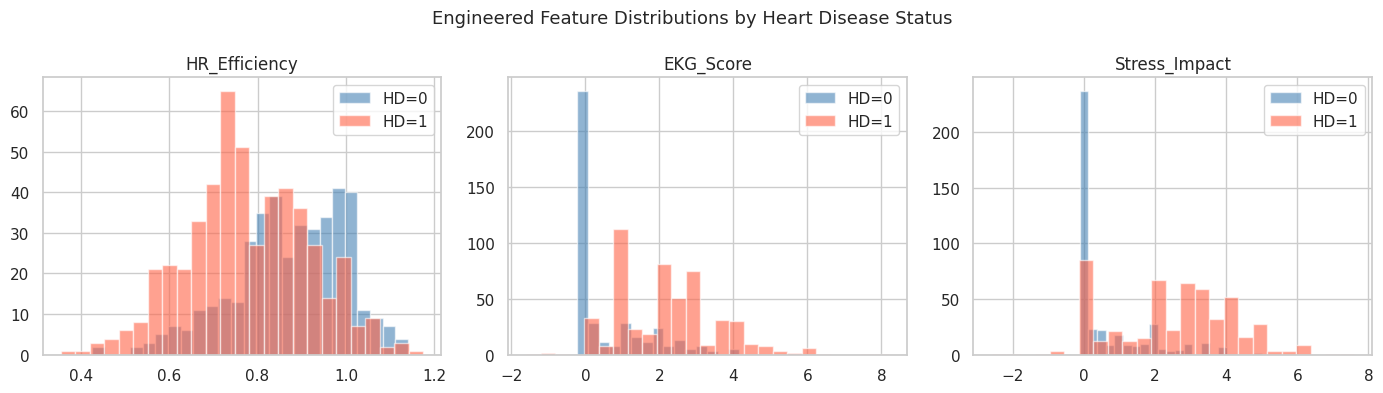

In [32]:
eng_features = ['HR_Efficiency', 'EKG_Score', 'Stress_Impact']
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(eng_features):
    for label, color in zip([0, 1], ['steelblue', 'tomato']):
        axes[i].hist(df_clean[df_clean['HeartDisease'] == label][col],
                     bins=25, alpha=0.6, color=color, label=f'HD={label}')
    axes[i].set_title(col)
    axes[i].legend()
plt.suptitle('Engineered Feature Distributions by Heart Disease Status', fontsize=13)
plt.tight_layout()
plt.show()

**Notes:**
- **HR_Efficiency** reveals a clear separation between the two groups. Healthy patients ($HD=0$) cluster near 1.0, (achieved predicted maximum HR). Heart disease patients ($HD=1$) skew significantly lower, (reduced cardiac efficiency relative to their age).
- **EKG_Severity** shows a strong rightward shift for the heart disease cohort, (higher combined risk from the interaction of ST slope and depression). Healthy individuals cluster tightly near zero(no significant EKG abnormalities).
- **Stress_Impact** shows a bimodal distribution for heart disease patients (physical angina and EKG ST-depression present). The healthy group remains heavily left-skewed, as they typically lack both symptoms, resulting in a near-zero score.

# Train / Validation / Test Split

**Goals:**
- Stratified **60/20/20** split on both the target class and gender simultaneously.
- A combined stratification key `strat_key` (e.g., `"M_1"`, `"F_0"`) is created so that each split preserves the male/female ratio *and* the HD/No-HD ratio. This prevents any fold or set from being accidentally male-heavy or female-heavy.
- StandardScaler is fit **only on training data** to prevent data leakage.

In [33]:
X = df_clean.drop('HeartDisease', axis=1)
y = df_clean['HeartDisease']

# Combined stratification key: sex + target
strat_key = X['Sex'].astype(str) + '_' + y.astype(str)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=strat_key)

strat_key_tv = X_train_val['Sex'].astype(str) + '_' + y_train_val.astype(str)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=SEED, stratify=strat_key_tv)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")
print(f"\nHD rate   — Train: {y_train.mean():.2%} | Val: {y_val.mean():.2%} | Test: {y_test.mean():.2%}")
print(f"Male rate — Train: {X_train['Sex'].mean():.2%} | Val: {X_val['Sex'].mean():.2%} | Test: {X_test['Sex'].mean():.2%}")

Train: 550 | Val: 184 | Test: 184

HD rate   — Train: 55.27% | Val: 55.43% | Test: 55.43%
Male rate — Train: 78.91% | Val: 79.35% | Test: 78.80%


In [34]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

# Modeling

**Goals:**
- `GridSearchCV` with a **combined-stratified** `StratifiedKFold` for hyperparameter tuning. The CV folds use the same combined sex+target key to ensure every fold during tuning also preserves gender balance.
- LR and SVM receive scaled data; XGBoost receives unscaled data (tree-based models are scale-invariant).
- Final evaluation is on the **held-out test set only**.

In [35]:
# Combined stratification key for cross-validation (on training set)
strat_key_train = X_train['Sex'].astype(str) + '_' + y_train.astype(str)

# Build CV splitter using the combined key
# Pass groups=strat_key_train to GridSearchCV via cv= a custom split
# Encode the combined key as integers, use StratifiedKFold on it
from sklearn.preprocessing import LabelEncoder as LE
strat_encoded = LE().fit_transform(strat_key_train)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv.split(X_train_sc, strat_encoded))

def evaluate(name, model, X_te, y_te, threshold=0.5):
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X_te)[:, 1]
    else:
        d = model.decision_function(X_te)
        probs = (d - d.min()) / (d.max() - d.min())
    preds = (probs >= threshold).astype(int)
    print(f"\n{'='*45}\n  {name}\n{'='*45}")
    print(classification_report(y_te, preds, target_names=['No HD', 'HD']))
    auc = roc_auc_score(y_te, probs)
    print(f"  ROC-AUC: {auc:.4f}")
    return {'name': name, 'probs': probs, 'preds': preds, 'auc': auc}

print("CV splits ready. Combined stratification (sex + target) applied.")

CV splits ready. Combined stratification (sex + target) applied.


### Logistic Regression

In [36]:
lr_params = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=SEED),
    lr_params, cv=cv_splits, scoring='roc_auc', n_jobs=-1
)
lr_grid.fit(X_train_sc, y_train)
print("Best params:", lr_grid.best_params_)
print("Best CV AUC:", f"{lr_grid.best_score_:.4f}")
lr_best = lr_grid.best_estimator_

Best params: {'C': 0.1, 'solver': 'lbfgs'}
Best CV AUC: 0.9319


In [37]:
lr_result = evaluate('Logistic Regression', lr_best, X_test_sc, y_test)


  Logistic Regression
              precision    recall  f1-score   support

       No HD       0.89      0.80      0.85        82
          HD       0.85      0.92      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184

  ROC-AUC: 0.9100


### Support Vector Machine

In [38]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(
    SVC(probability=True, random_state=SEED),
    svm_params, cv=cv_splits, scoring='roc_auc', n_jobs=-1
)
svm_grid.fit(X_train_sc, y_train)
print("Best params:", svm_grid.best_params_)
print("Best CV AUC:", f"{svm_grid.best_score_:.4f}")
svm_best = svm_grid.best_estimator_

Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV AUC: 0.9333


In [39]:
svm_result = evaluate('SVM', svm_best, X_test_sc, y_test)


  SVM
              precision    recall  f1-score   support

       No HD       0.92      0.79      0.85        82
          HD       0.85      0.94      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184

  ROC-AUC: 0.9078


### XGBoost

In [40]:
# Use unscaled data (tree-based, scale-invariant)
# Re-build cv_splits on unscaled training data (same indices, same splits)
strat_encoded_xgb = LE().fit_transform(strat_key_train)
cv_splits_xgb = list(cv.split(X_train, strat_encoded_xgb))

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(eval_metric='logloss', random_state=SEED, verbosity=0),
    xgb_params, cv=cv_splits_xgb, scoring='roc_auc', n_jobs=-1
)
xgb_grid.fit(X_train, y_train)
print("Best params:", xgb_grid.best_params_)
print("Best CV AUC:", f"{xgb_grid.best_score_:.4f}")
xgb_best = xgb_grid.best_estimator_

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV AUC: 0.9311


In [41]:
xgb_result = evaluate('XGBoost', xgb_best, X_test, y_test)


  XGBoost
              precision    recall  f1-score   support

       No HD       0.94      0.77      0.85        82
          HD       0.84      0.96      0.89       102

    accuracy                           0.88       184
   macro avg       0.89      0.86      0.87       184
weighted avg       0.88      0.88      0.87       184

  ROC-AUC: 0.9379


### Neural Network (MLP) — PyTorch

A compact 3-layer MLP with BatchNorm, Dropout, and early stopping.

Early stopping at epoch 27


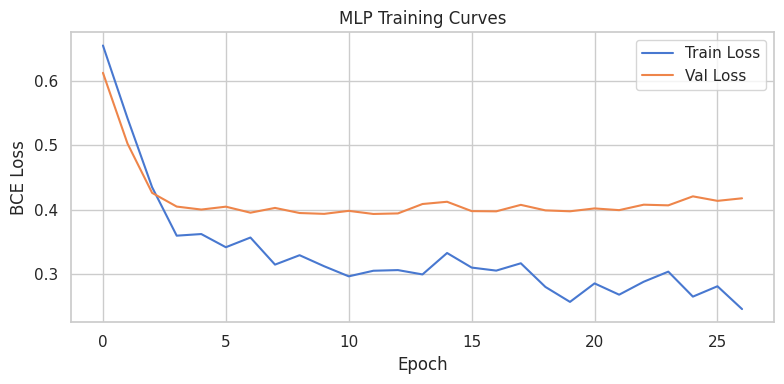

In [43]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)


def make_tensors(X, y):
    return TensorDataset(torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(y)))


train_ds = make_tensors(X_train_sc, y_train)
val_ds   = make_tensors(X_val_sc, y_val)
test_ds  = make_tensors(X_test_sc, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)
test_loader  = DataLoader(test_ds,  batch_size=64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(X_train_sc.shape[1]).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss()

best_val_loss = float('inf')
patience, patience_counter = 15, 0
best_weights = None
train_losses, val_losses = [], []

for epoch in range(150):
    # Training
    mlp.train()
    t_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(mlp(Xb), yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    train_losses.append(t_loss / len(train_loader))

    # Evaluating
    mlp.eval()
    v_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            v_loss += criterion(mlp(Xb), yb).item()
    val_losses.append(v_loss / len(val_loader))

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_weights = {k: v.clone() for k, v in mlp.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

mlp.load_state_dict(best_weights)

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('MLP Training Curves')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
mlp.eval()
all_probs = []
with torch.no_grad():
    for Xb, _ in test_loader:
        all_probs.extend(mlp(Xb.to(device)).cpu().numpy())

mlp_probs = np.array(all_probs)
mlp_preds = (mlp_probs >= 0.5).astype(int)

print("\n" + "="*45 + "\n  MLP (PyTorch)\n" + "="*45)
print(classification_report(y_test, mlp_preds, target_names=['No HD', 'HD']))
mlp_auc = roc_auc_score(y_test, mlp_probs)
print(f"  ROC-AUC: {mlp_auc:.4f}")
mlp_result = {'name': 'MLP (PyTorch)', 'probs': mlp_probs, 'preds': mlp_preds, 'auc': mlp_auc}


  MLP (PyTorch)
              precision    recall  f1-score   support

       No HD       0.90      0.79      0.84        82
          HD       0.85      0.93      0.89       102

    accuracy                           0.87       184
   macro avg       0.88      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184

  ROC-AUC: 0.9134


# Model Evaluation & Comparison

### Confusion Matrices

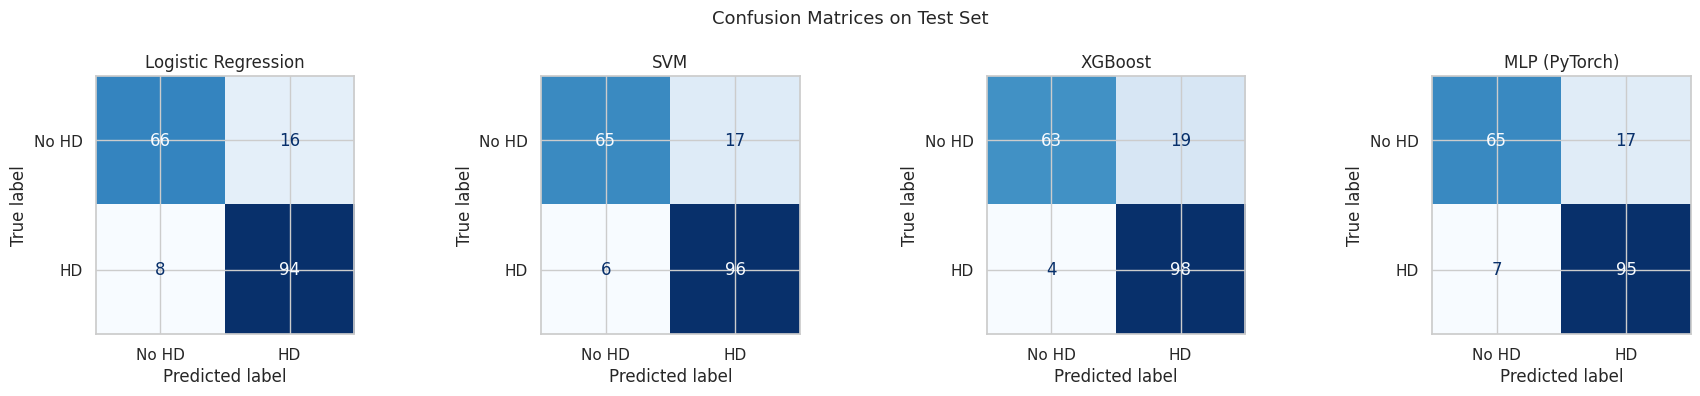

In [45]:
results = [lr_result, svm_result, xgb_result, mlp_result]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for ax, res in zip(axes, results):
    cm = confusion_matrix(y_test, res['preds'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['No HD', 'HD'])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(res['name'])
plt.suptitle('Confusion Matrices on Test Set', fontsize=13)
plt.tight_layout()
plt.show()

### ROC Curves

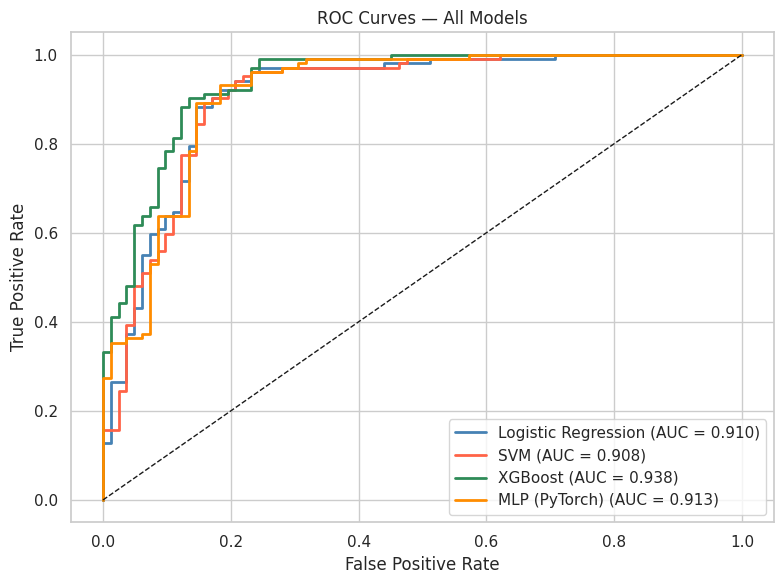

In [46]:
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'tomato', 'seagreen', 'darkorange']
for res, color in zip(results, colors):
    fpr, tpr, _ = roc_curve(y_test, res['probs'])
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{res['name']} (AUC = {res['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — All Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Metrics Comparison Table

In [47]:
summary = []
for res in results:
    summary.append({
        'Model': res['name'],
        'Accuracy':  round(accuracy_score(y_test, res['preds']), 4),
        'Precision': round(precision_score(y_test, res['preds']), 4),
        'Recall':    round(recall_score(y_test, res['preds']), 4),
        'F1':        round(f1_score(y_test, res['preds']), 4),
        'ROC-AUC':   round(res['auc'], 4)
    })

summary_df = pd.DataFrame(summary).set_index('Model')
print(summary_df.to_string())

                     Accuracy  Precision  Recall      F1  ROC-AUC
Model                                                            
Logistic Regression    0.8696     0.8545  0.9216  0.8868   0.9100
SVM                    0.8750     0.8496  0.9412  0.8930   0.9078
XGBoost                0.8750     0.8376  0.9608  0.8950   0.9379
MLP (PyTorch)          0.8696     0.8482  0.9314  0.8879   0.9134


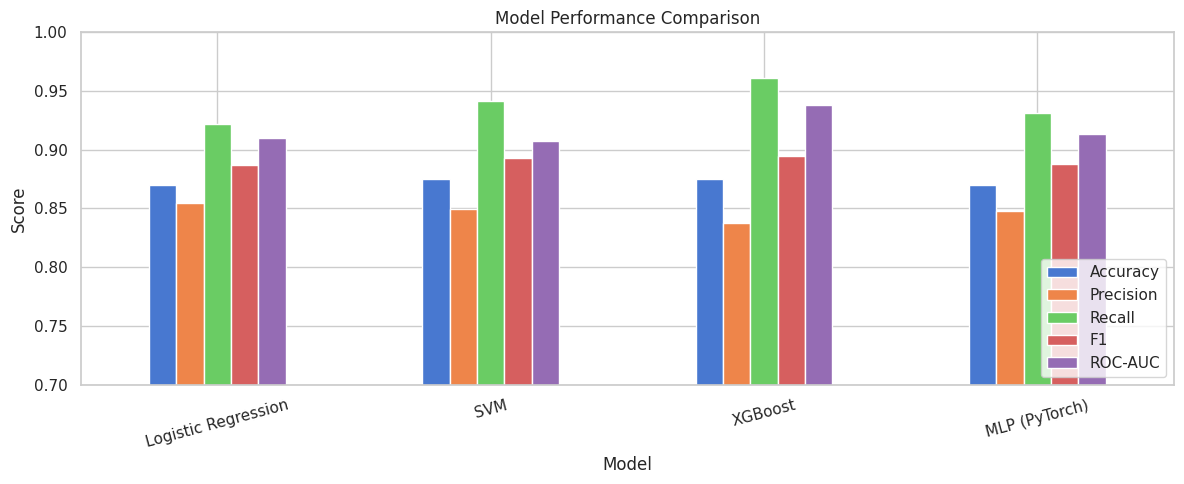

In [48]:
summary_df.plot(kind='bar', figsize=(12, 5), edgecolor='white')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=15)
plt.ylim(0.7, 1.0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### XGBoost Feature Importance

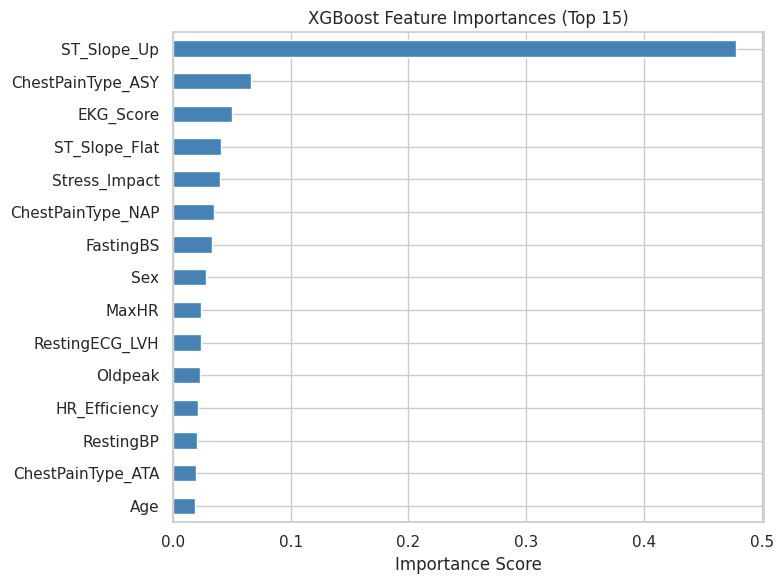

In [49]:
importances = pd.Series(xgb_best.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True).tail(15)

plt.figure(figsize=(8, 6))
importances.plot(kind='barh', color='steelblue', edgecolor='white')
plt.title('XGBoost Feature Importances (Top 15)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

### Logistic Regression Coefficients

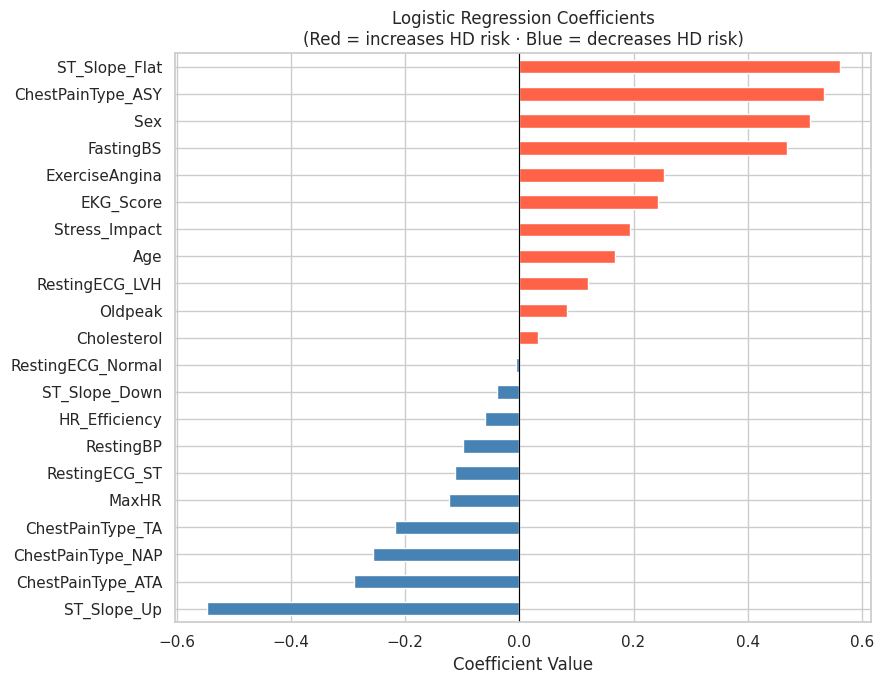

In [50]:
coefs = pd.Series(lr_best.coef_[0], index=X.columns).sort_values()
colors_bar = ['tomato' if c > 0 else 'steelblue' for c in coefs]

plt.figure(figsize=(9, 7))
coefs.plot(kind='barh', color=colors_bar, edgecolor='white')
plt.axvline(0, color='black', lw=0.8)
plt.title('Logistic Regression Coefficients\n(Red = increases HD risk · Blue = decreases HD risk)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

# Conclusions
---
**Model Performance and Selection**
- XGBoost is the Optimal Model. XGBoost achieved the highest ROC-AUC (0.94) and Recall (0.96) scores, making it the most reliable model for detecting heart disease in this dataset.
- XGBoose shows high diagnostic sensitivity, as its confusion matrix shows it correctly identified 98 out of 102 heart disease cases, resulting in only 4 false negatives.
- While XGBoost leads in accuracy, Logistic Regression provides valuable clinical transparency by showing exactly how much each factor increases or decreases patient risk.
- The MLP model performed well but did not outperform XGBoost.This confirms that for smaller tabular datasets, gradient boosting is often more effective than neural networks.
---
**Some Clinical Insights**
- An Asymptomatic (ASY) chest pain type and a Flat ST Slope are the strongest risk markers of heart disease across all models.
- A healthy Upward ST Slope and a high Maximum Heart Rate (MaxHR) are the strongest signals that a patient does not have heart disease.
- The engineered `EKG_Score` and `Stress_Impact` features both ranked in the top five for feature importance.
---
**Technical Details**:
- After imputing the 0-value errors, Cholesterol and RestingBP contributed logically to the models, whereas they previously provided misleading negative correlations.
- By using Stratified Cross-Validation, the project ensured that the significant gender imbalance (~79% male) did not bias the results or inflate accuracy scores.
- Prioritizing Recall Over Precision: In medical screening, Recall is the priority because the cost of missing a sick patient (False Negative) is much higher than the cost of a false alarm (False Positive).



